In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

In [15]:

data_dir = "/home/jruffio/code/jwst_scripts/HD_19467_B/data/"
RDI_1dspectrum_speckles_filename = os.path.join(data_dir,"HD19467b_RDI_1dspectrum_speckles_Flambda_modified.fits")
RDI_1dspectrum_spectra_filename = os.path.join(data_dir,"HD19467b_RDI_1dspectrum_Flambda_modified.fits")
covariance_filename = os.path.join(data_dir,"HD19467b_covariance.fits")
with fits.open(RDI_1dspectrum_spectra_filename) as hdulist:
    wave = hdulist[0].data 
    spec = hdulist[1].data 
    err = hdulist[2].data
    err_hpf = hdulist[3].data 
    
with fits.open(covariance_filename) as hdulist:
    covariance = hdulist[0].data
    valid = hdulist[1].data
    cov_inv = hdulist[2].data

In [16]:
# This cell contains data from a precomputed R=2700 gaussian kernel broadened cloudy equilibrium chemistry atmosphere model
# with parameters
# T = 1400, g = 3160, logKz = 7, MH = 0.5, CO = 1.0, fsed = 3
Lambda = np.load(os.path.join(data_dir,"model_Teff1400_wvs.npy"))
F_Lambda = np.load(os.path.join(data_dir,"model_Teff1400_flux.npy"))

# Important constants
Rjup = 6.995e7 #ma
pc = 3.086e16 #m

In [17]:
#we will compute chi2 over a small grid of planetary radii to find the best fit radius

radii = np.logspace(-0.5,0.5,21)
chi2s = []

for Rplanet in radii:
    d2f = (Rplanet*Rjup/(30.86*pc))**2                     # scaling factor for planet radius and distance 
    F_downsampled = np.interp(wave[valid],Lambda,F_Lambda) # sample model on valid wavelength to match spectra
    v = (F_downsampled*d2f - spec[valid])                  # model - data vector
    chi2 = np.linalg.multi_dot([v.T,cov_inv,v])            # compute covariance as dot product vT C-1 v
    chi2s.append(chi2)

i = np.argmin(chi2s)
d2f_best = (radii[i]*Rjup/(30.86*pc))**2
print('chi2 = {}, R = {} Rjup'.format(chi2s[i],radii[i]))

chi2 = 21332.90920472473, R = 0.6309573444801934 Rjup


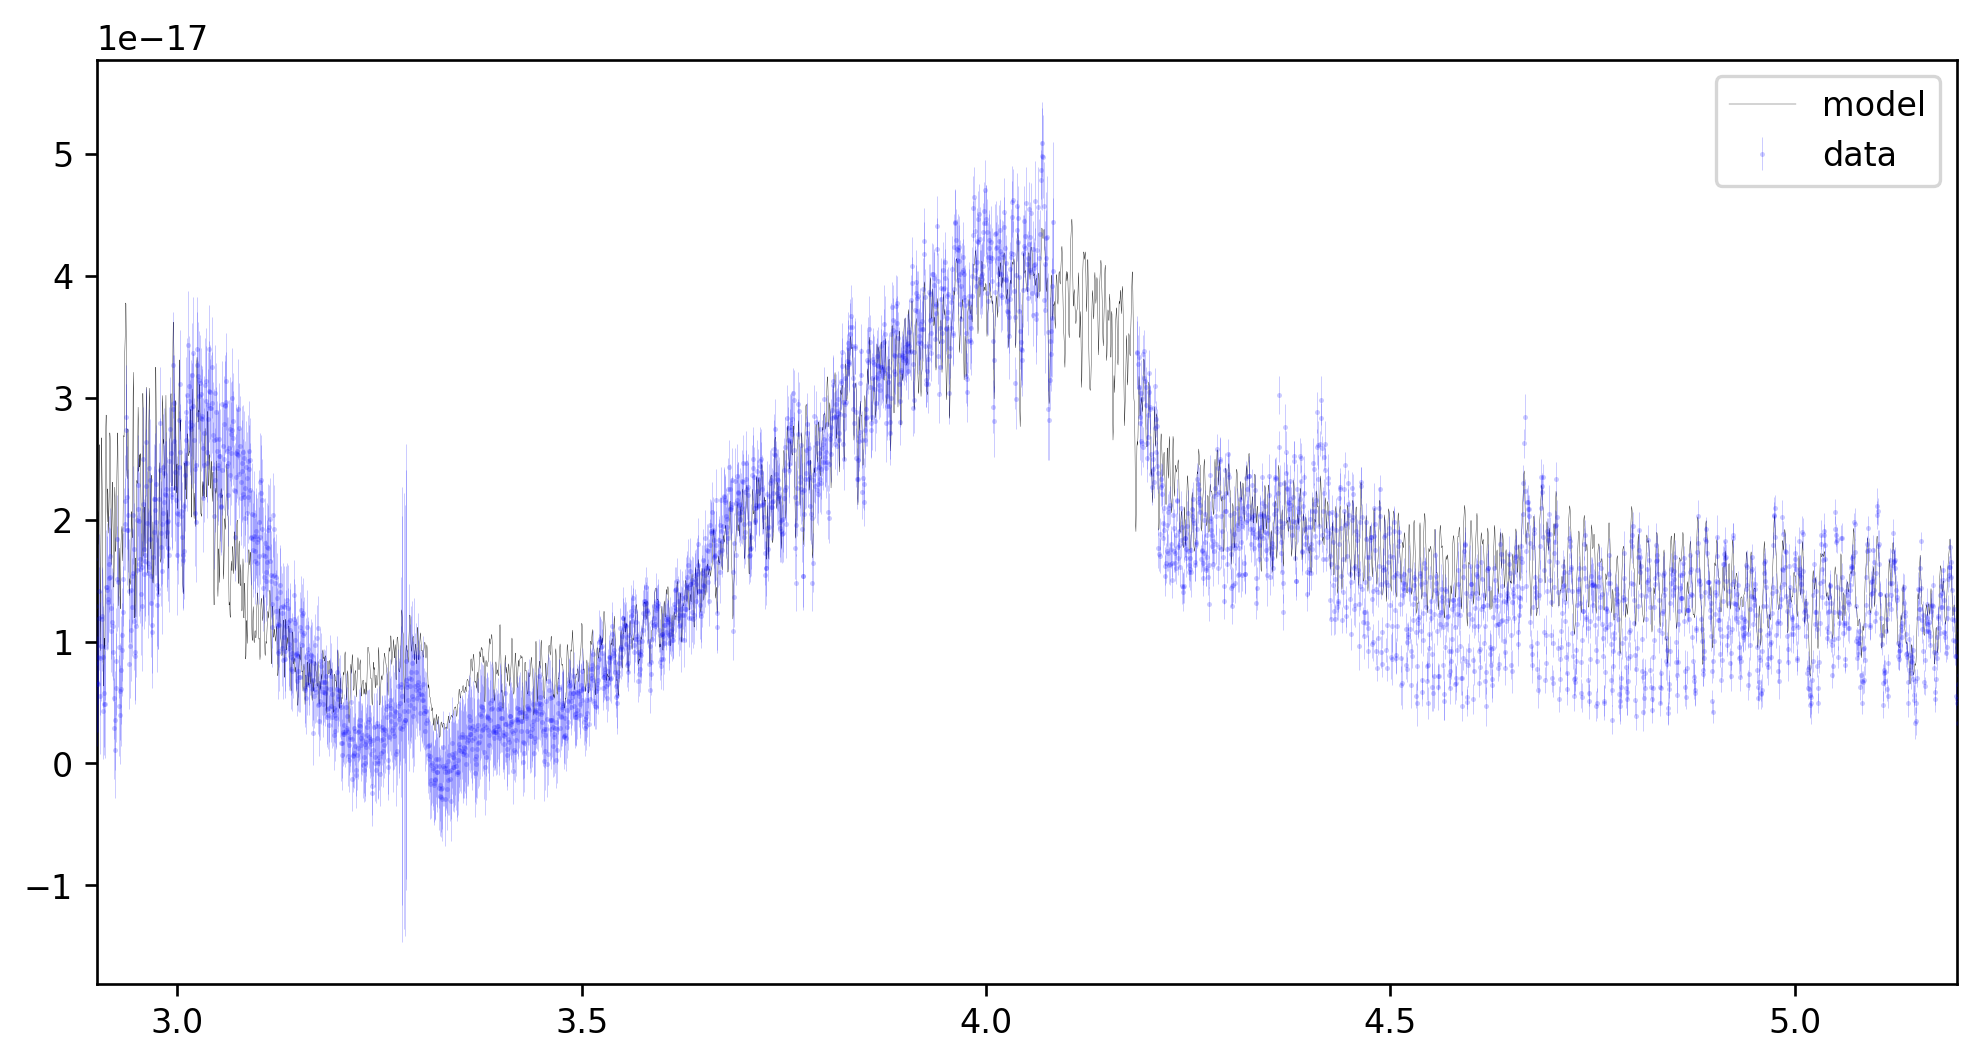

In [18]:
plt.figure(figsize=(10,5),dpi=240)
plt.plot(Lambda,F_Lambda*d2f_best,'k-',linewidth=.1,alpha=1)
plt.errorbar(wave,spec,err,markersize=1,marker='.',linestyle='none',linewidth=.3,color='b',alpha=.2,zorder=10)
plt.xlim([2.9,5.2])
plt.legend(['model','data'])
plt.show()